<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture1/save_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SaveとLoad

In [ ]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split

## early stopping

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=False):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.X[idx], self.y[idx]

class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_din):
        super().__init__()
        self.flatten = nn.Flatten()
        self.block = nn.Sequential(
            nn.Linear(input_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, output_din)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.block(x)
        return x

# 学習ループを関数化
def learn(model, train_loader, val_loader, optimizer, loss_func, epochs, early_stopping=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数

    for epoch in range(epochs):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0

        for train_batch, data in enumerate(train_loader):
            X, y = data
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_func(y_pred, y)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()

        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')

        # early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
        else:
            no_improve += 1

        if early_stopping and no_improve >= early_stopping:
            print('early stopping')
            break

    return train_losses, val_losses, val_accuracies

In [ ]:
# データロード
dataset = datasets.load_digits()
target = dataset['target']
images = dataset['images']
images = images * (255. / 16.) # 0~16 -> 0~255
images = images.astype(np.uint8)
# 学習データと検証データ作成
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# DatasetとDataLoader作成
transform = transforms.Compose([
    transforms.ToTensor(),# 0~255 -> 0~1
    transforms.Normalize((.5, ), (.5, )) # 0~1 -> -1~1
])

batch_size = 32
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
early_stopping = 5
## Refactoring後の学習ループ
learning_rate = 0.1
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
num_epoch = 100
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5)

epoch: 0: train error: 1.8704739014307659, validation error: 1.2660809655984242, validation accuracy: 0.7864583333333334
epoch: 1: train error: 0.8187030792236328, validation error: 0.533705860376358, validation accuracy: 0.9140625
epoch: 2: train error: 0.41075304680400426, validation error: 0.33392229427893955, validation accuracy: 0.9296875
epoch: 3: train error: 0.27966736753781635, validation error: 0.24689303090174994, validation accuracy: 0.9427083333333334
epoch: 4: train error: 0.21738298568460676, validation error: 0.22281160950660706, validation accuracy: 0.9401041666666666
epoch: 5: train error: 0.18571470561954712, validation error: 0.1840834574153026, validation accuracy: 0.953125
epoch: 6: train error: 0.1634753471447362, validation error: 0.15624616978069147, validation accuracy: 0.9505208333333334
epoch: 7: train error: 0.14743212345573636, validation error: 0.15557104845841727, validation accuracy: 0.9505208333333334
epoch: 8: train error: 0.1317964465667804, validati

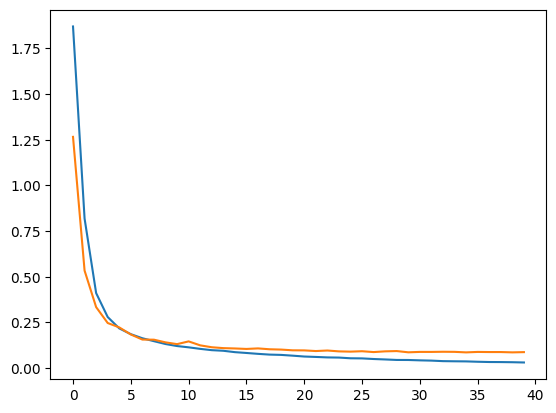

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

## モデルオブジェクトの保存とロード

モデル全体を保村するときには、一般的に拡張子ptが用いられる

In [ ]:
torch.save(model, "sample_model.pt")
loaded_model = torch.load("sample_model.pt")
loaded_model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (block): Sequential(
    (0): Linear(in_features=64, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)

## モデルのパラメータの保存とロード

モデルのパラメータのみを保存する場合には、一般的に拡張子pthで保存されることが多い。

In [ ]:
params = model.state_dict()
another_model = MLP(64, 30, 10)
another_model.load_state_dict(params)

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), 'sample_model_state_dict.pth')
another_model.load_state_dict(torch.load('sample_model_state_dict.pth'))

<All keys matched successfully>

In [ ]:
# モデル保存付き
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数

    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0

        for train_batch, data in enumerate(train_loader):

            X, y = data
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()

            # backward
            loss.backward()
            optimizer.step()

        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()

        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1

        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break

    return train_losses, val_losses, val_accuracies

In [ ]:
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5, save_path='checkparm')

epoch: 0: train error: 1.7474647071626452, validation error: 1.090665449698766, validation accuracy: 0.8255208333333334
epoch: 1: train error: 0.7305539608001709, validation error: 0.521380419532458, validation accuracy: 0.8723958333333334
epoch: 2: train error: 0.4069489538669586, validation error: 0.343248891333739, validation accuracy: 0.921875
epoch: 3: train error: 0.2825710952281952, validation error: 0.2936784029006958, validation accuracy: 0.8932291666666666
epoch: 4: train error: 0.22919729467895295, validation error: 0.22178655986984572, validation accuracy: 0.9348958333333334
epoch: 5: train error: 0.19245588646994696, validation error: 0.19005835553010306, validation accuracy: 0.9505208333333334
epoch: 6: train error: 0.1669131923880842, validation error: 0.17540879423419634, validation accuracy: 0.9505208333333334
epoch: 7: train error: 0.15114641421371036, validation error: 0.15769076409439245, validation accuracy: 0.9583333333333334
epoch: 8: train error: 0.1351492131749

In [ ]:
state = torch.load('checkparm')
model.load_state_dict(state['model_state_dict'])
opt.load_state_dict(state['optimizer_state_dict'])